In [63]:
import csv
import cv2
import numpy as np

champtoi = {}
itochamp = {}
with open('champions.csv') as f:
    reader = csv.reader(f)
    header = next(reader)
    for i, row in enumerate(reader):
        champtoi[row[0]] = i        
        itochamp[i] = row[0]

champtoi['Ability'] = len(champtoi)
itochamp[len(champtoi) - 1] = 'Ability'
champtoi['Pet'] = len(champtoi)
itochamp[len(champtoi) - 1] = 'Pet'

In [55]:
import xml.etree.ElementTree as ET

def parse_pascal_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    boxes = []
    labels = []

    for obj in root.findall('object'):
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(champtoi[name])  

    return boxes, labels

In [135]:
NUM_IMAGES = 10

In [137]:
import os
import random

random.seed(42)

img_boxes = os.listdir("/Users/HP/Documents/GitHub/JusticeGarenteed/greenscreends/train/")

imgs = sorted([img for img in img_boxes if img.endswith(".jpg")])
xmls = sorted([xml for xml in img_boxes if xml.endswith(".xml")])

indices = random.sample(range(len(imgs)), NUM_IMAGES)
sampled_imgs = ['../greenscreends/train/' + imgs[i] for i in indices]
sampled_xmls = ['../greenscreends/train/' + xmls[i] for i in indices]


In [7]:
import matplotlib.pyplot as plt

def plot_image_with_boxes(img, boxes, labels):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10), dpi = 200)
    plt.imshow(img_rgb)
    
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=1))
        plt.text(xmin, ymin -25, str(itochamp[label]), color='red', fontsize=7)

    plt.axis('off')
    plt.show()

In [131]:
def alpha_from_green_distance(img, strength = 0.9):
    """
    Estimate alpha based on how different the pixel is from green.
    
    :param strength: How much to amplify the difference from green.
        Higher strengths amplify difference between green and other colors.
        Lower the strength to make the alpha mask more forgiving (more of the original background remains/shows through the subject)
    :return: Alpha mask where green is 0 and other colors are 1.
    """

    img = img.astype(np.float32) / 255.0
    green = np.array([0, 1, 0], dtype=np.float32)
    diff = np.linalg.norm(img - green, axis=2)
    alpha_mask = np.clip(diff * strength, 0, 1)
    return alpha_mask

def despill(img, alpha, strength=0.75):
    """
    Reduce green from semi-transparent regions.
    
    :param float strength: How much to reduce green in the image.
        Higher values reduce more green, but may affect other colors.
        Lower values preserve more of the original image.
    """
    img = img.astype(np.float32) / 255.0
    alpha_exp = np.expand_dims(alpha, axis=-1)
    
    # Desaturate green where alpha is low
    green_reduction = (1 - alpha_exp[..., 0]) * strength
    img[..., 1] -= green_reduction
    img = np.clip(img, 0, 1)
    return img

def flatten_alpha_and_erase_green(rgba, erase_threshold=0.25):
    rgb = rgba[..., :3].astype(np.float32) / 255.0
    alpha = rgba[..., 3:] / 255.0

    # Zero out pixels where alpha is too low (erases green haze)
    mask = alpha > erase_threshold
    rgb = rgb * mask  # remove RGB where alpha is approx 0

    result = (rgb * 255).astype(np.uint8)
    return result

def chroma_key_preserve_glow(img_bgr, mask_col = [0,0,0]):
    img = img_bgr.copy()
    alpha = alpha_from_green_distance(img)
    alpha = cv2.GaussianBlur(alpha, (5, 5), 0)  # Feather for smoother transitions
    img_despilled = despill(img, alpha)

    rgba = np.dstack([img_despilled, alpha])
    rgba = (rgba * 255).astype(np.uint8)
    flattened = flatten_alpha_and_erase_green(rgba)
    # Mask out mask_col areas
    mask = np.all(flattened[..., :3] <= mask_col, axis=-1)
    flattened[mask] = [255, 255, 255]  # Set mask_col areas to white
    return flattened 


def clean_background_artifacts(img_bgr, green_bgr=(0, 255, 0), threshold=45):
    img = img_bgr.astype(np.float32)
    green = np.array(green_bgr, dtype=np.float32)

    # Compute distance from green color
    diff = np.linalg.norm(img - green, axis=2)

    # Create mask: preserve areas that differ enough from green
    mask_keep = (diff > threshold).astype(np.uint8)

    # Morphological open to clean up specks
    kernel = np.ones((3, 3), np.uint8)
    mask_keep = cv2.morphologyEx(mask_keep, cv2.MORPH_OPEN, kernel)

    # Replace non-kept regions with solid green
    cleaned = img.copy()
    cleaned[mask_keep == 0] = green

    return cleaned.astype(np.uint8)

def suppress_green_hue(rgb_img, hue_range=(40, 110), sat_thresh=60, val_thresh=50, shift_hue_by=0, desat_factor=0.95):
    """
    Suppress lime green hues remaining in the RGB image by shifting hue away from green.
    - hue_range: HSV hue range to treat as green (in degrees: 0–180 for OpenCV)
    - sat_thresh: minimum saturation to consider (to skip gray/white)
    - val_thresh: minimum value to consider (to skip very dark areas)
    - shift_hue_by: how much to shift hue away from green (e.g. +20)
    """
    img_hsv = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)

    H, S, V = img_hsv[..., 0], img_hsv[..., 1], img_hsv[..., 2]
    green_mask = (
        (H >= hue_range[0]) & (H <= hue_range[1]) &
        (S >= sat_thresh) & (V >= val_thresh)
    )

    # Shift hue for green pixels away from green (wrap around if needed)
    img_hsv[..., 0][green_mask] = (img_hsv[..., 0][green_mask] + shift_hue_by) % 180

    # Optionally, desaturate a bit
    img_hsv[..., 1][green_mask] = (img_hsv[..., 1][green_mask] * desat_factor).astype(np.uint8)

    result = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    return result

def suppress_only_lime(rgb_img, hue_range=(60, 75), sat_thresh=80, val_thresh=60, desat_strength=0.3):
    """
    Suppress only pure lime green hues by desaturating them softly.
    No hue shift; preserves warm yellows and oranges.
    """
    img_hsv = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV).astype(np.float32)

    H, S, V = img_hsv[..., 0], img_hsv[..., 1], img_hsv[..., 2]
    green_mask = (
        (H >= hue_range[0]) & (H <= hue_range[1]) &
        (S >= sat_thresh) & (V >= val_thresh)
    )

    # Desaturate only pure lime pixels slightly
    img_hsv[..., 1][green_mask] *= (1 - desat_strength)
    img_hsv = np.clip(img_hsv, 0, 255).astype(np.uint8)

    return cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

def context_aware_despill(rgb_img, alpha, green_thresh=0.28, blur_kernel=13, suppress_strength=0.5):
    """
    More aggressively remove green while preserving glow. No hue shifting.
    - Suppresses green using color distance AND alpha mask
    """
    rgb = rgb_img.astype(np.float32) / 255.0

    # Define green color in normalized RGB
    target_green = np.array([0.0, 1.0, 0.0])

    # Euclidean distance from pure green
    dist_from_green = np.linalg.norm(rgb - target_green, axis=2)
    green_mask = (dist_from_green < green_thresh) & (alpha > 0.15)

    # Generate blurred fallback image (local context)
    blurred_rgb = cv2.blur(rgb, (blur_kernel, blur_kernel))

    # Adaptive desaturation toward local blurred average
    rgb_out = rgb.copy()
    for c in range(3):
        rgb_out[..., c][green_mask] = (
            (1 - suppress_strength) * rgb[..., c][green_mask] +
            suppress_strength * blurred_rgb[..., c][green_mask]
        )

    rgb_out = np.clip(rgb_out, 0, 1)
    return (rgb_out * 255).astype(np.uint8)


In [133]:
def chroma_key_with_glow_preservation(
    img_bgr,
    green_strength=0.9,
    despill_strength=0.75,
    blur_radius=5,
    erase_threshold=0.25,
    mask_color=(0, 0, 0),
    output_white_background=True
):
    """
    Applies green screen removal while preserving semi-transparent glow/VFX.

    Parameters:
        img_bgr (np.ndarray): Input image in BGR format.
        green_strength (float): Amplifies the difference from green (for alpha creation).
        despill_strength (float): How much green to remove in semi-transparent regions.
        blur_radius (int): Gaussian blur kernel size for feathering alpha.
        erase_threshold (float): Threshold for removing green haze via alpha masking.
        mask_color (tuple): RGB color to erase from the final image (e.g., (0, 0, 0) for black).
        output_white_background (bool): If True, masked areas are replaced with white, otherwise black.

    Returns:
        np.ndarray: Output RGB image with green screen removed and background masked.
    """
    # Normalize image
    img = img_bgr.astype(np.float32) / 255.0

    # Estimate alpha based on green distance
    green = np.array([0, 1, 0], dtype=np.float32)
    diff = np.linalg.norm(img - green, axis=2)
    alpha = np.clip(diff * green_strength, 0, 1)
    alpha = cv2.GaussianBlur(alpha, (blur_radius, blur_radius), 0)

    # Despill green based on alpha
    alpha_exp = np.expand_dims(alpha, axis=-1)
    green_reduction = (1 - alpha_exp) * despill_strength
    img[..., 1] -= green_reduction[..., 0]
    img = np.clip(img, 0, 1)

    # Combine into RGBA
    rgba = np.dstack([img, alpha])
    rgba = (rgba * 255).astype(np.uint8)

    # Flatten by removing green haze with low alpha
    rgb = rgba[..., :3].astype(np.float32) / 255.0
    alpha_channel = rgba[..., 3:] / 255.0
    mask = alpha_channel > erase_threshold
    rgb *= mask
    flattened = (rgb * 255).astype(np.uint8)

    # Replace masked out areas with white or black
    mask_color_array = np.array(mask_color, dtype=np.uint8)
    mask = np.all(flattened <= mask_color_array, axis=-1)
    flattened[mask] = [255, 255, 255] if output_white_background else [0, 0, 0]

    return flattened

In [ ]:
def center_crop_with_bboxes(image, bboxes, crop_fraction):
    """
    Center-crops the image while preserving aspect ratio and updates VOC-format bounding boxes.

    Parameters:
        image (np.ndarray): Original image (H, W, C)
        bboxes (List[List[int]]): Bounding boxes [[x_min, y_min, x_max, y_max], ...]
        crop_fraction (float): Fraction (0 < f < 1) of the shorter side to crop on each side

    Returns:
        cropped_image (np.ndarray): The cropped image
        new_bboxes (List[List[int]]): Updated bounding boxes
    """
    assert 0 < crop_fraction < 0.5, "crop_fraction must be between 0 and 0.5"

    H, W, _ = image.shape
    crop_size = crop_fraction * min(H, W)

    # Compute crop bounds
    top = int(crop_size)
    left = int(crop_size)
    bottom = H - top
    right = W - left

    # Crop image
    cropped_image = image[top:bottom, left:right]

    # Update bounding boxes
    new_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        # Shift coordinates
        x_min_new = max(0, x_min - left)
        y_min_new = max(0, y_min - top)
        x_max_new = max(0, x_max - left)
        y_max_new = max(0, y_max - top)

        # Clip to image bounds
        x_min_new = min(x_min_new, right - left)
        x_max_new = min(x_max_new, right - left)
        y_min_new = min(y_min_new, bottom - top)
        y_max_new = min(y_max_new, bottom - top)

        # Optionally discard invalid boxes (zero area)
        if x_max_new > x_min_new and y_max_new > y_min_new:
            new_bboxes.append([x_min_new, y_min_new, x_max_new, y_max_new])

    return cropped_image, new_bboxes
img = cv2.imread(sampled_imgs[1])
boxes, labels = parse_pascal_voc_xml(sampled_xmls[1])
plot_image_with_boxes(img, boxes, labels)
cropped_image, new_bboxes = center_crop_with_bboxes(img, boxes, 0.1)
plot_image_with_boxes(cropped_image, new_bboxes, labels)


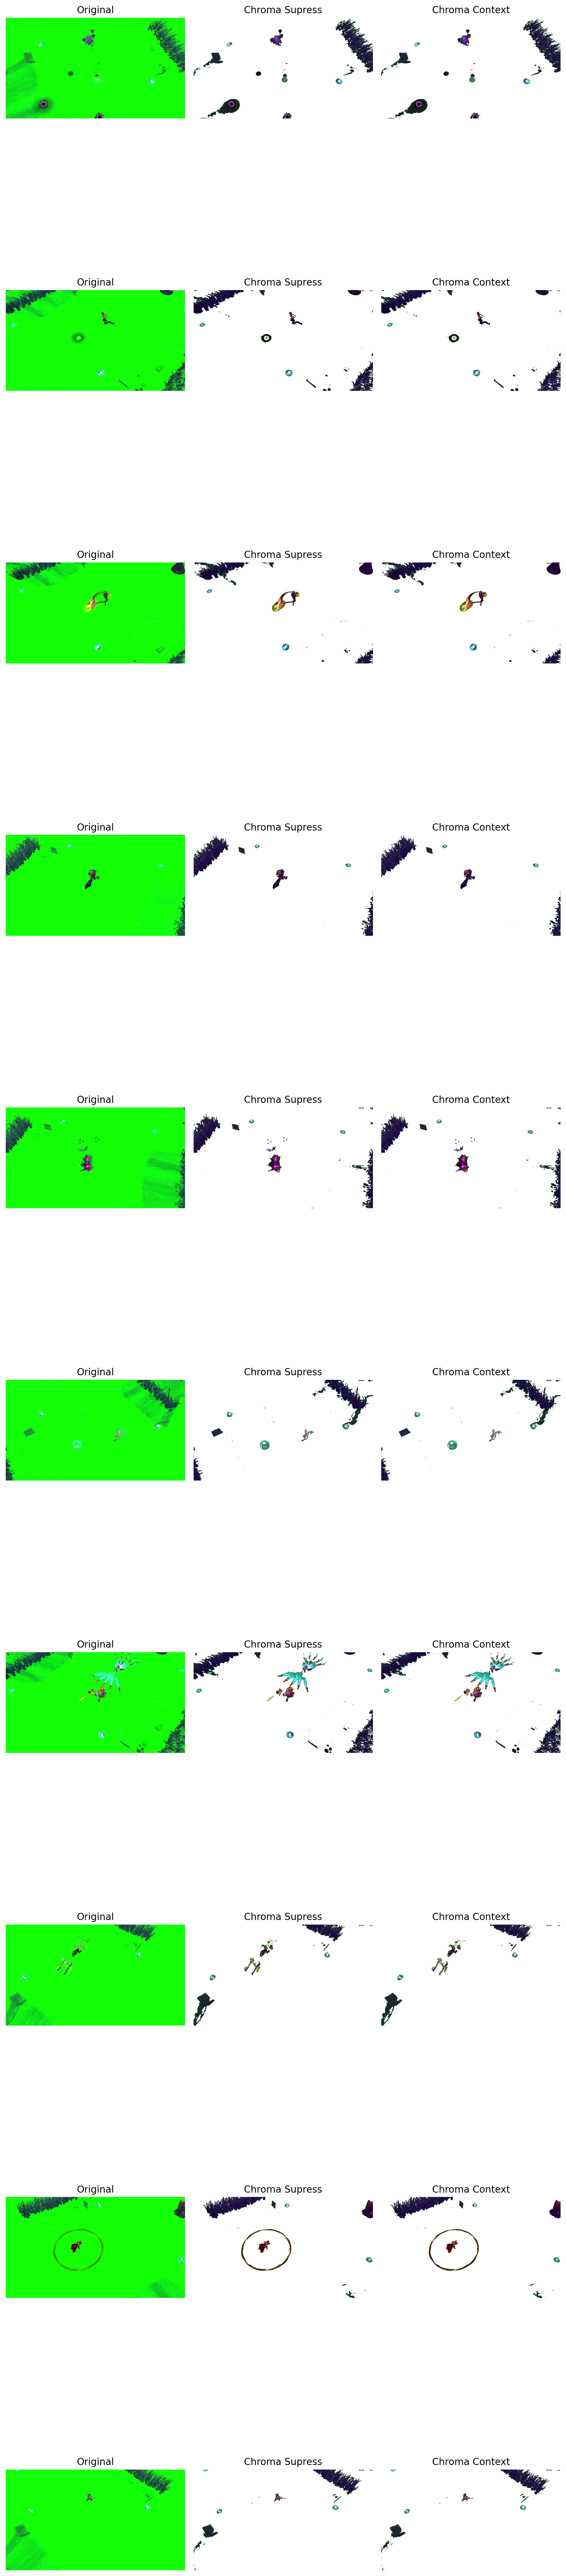

In [138]:
rows = len(sampled_imgs) 
 
fig, axes = plt.subplots(rows, ncols=3, figsize = (10, 5 * rows), dpi=200)
fig.subplots_adjust(hspace=0.01, wspace=0.1)

for i, (img_path, xml_path) in enumerate(zip(sampled_imgs, sampled_xmls)):
    boxes, labels = parse_pascal_voc_xml(xml_path)
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

    axes[i][0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i][0].axis('off')
    axes[i][0].set_title(f"Original")
    img_clean = clean_background_artifacts(img, green_bgr=(0, 255, 0), threshold=60)
    
    # masked = draw_matting(img_path)
    chroma = chroma_key_with_glow_preservation(img_clean)
    # chroma_suppress = suppress_only_lime(chroma, hue_range=(62, 73), sat_thresh=80, val_thresh=60, desat_strength=0.25)

    axes[i][1].imshow(cv2.cvtColor(chroma, cv2.COLOR_BGR2RGB))
    axes[i][1].axis('off')
    axes[i][1].set_title("Chroma Supress")
    
    alpha = alpha_from_green_distance(chroma)
    alpha = cv2.GaussianBlur(alpha, (5, 5), 0)  # soften transitions
    chroma_context = context_aware_despill(chroma, alpha=alpha)

    axes[i][2].imshow(cv2.cvtColor(chroma_context, cv2.COLOR_BGR2RGB))
    axes[i][2].axis('off')
    axes[i][2].set_title("Chroma Context")

plt.tight_layout()
plt.show()

In [ ]:
import cv2

img_paths = ["../LeagueGreenScreenChampions.v1i.voc/train/aurelionsol_train_00014_png.rf.116adfae64a462db461f518cbe3f525f.jpg", 
            "/Users/HP/Documents/GitHub/JusticeGarenteed/LeagueGreenScreenChampions.v1i.voc/train/aatrox_train_00019_png.rf.6094ab46722c9aa1519edd6afd65664d.jpg", 
            "/Users/HP/Documents/GitHub/JusticeGarenteed/LeagueGreenScreenChampions.v1i.voc/train/aatrox_train_00017_png.rf.6083c80923e891ed7bd62bcace7a4382.jpg"]

xml_paths = ["/Users/HP/Documents/GitHub/JusticeGarenteed/LeagueGreenScreenChampions.v1i.voc/train/aurelionsol_train_00014_png.rf.116adfae64a462db461f518cbe3f525f.xml", 
            "/Users/HP/Documents/GitHub/JusticeGarenteed/LeagueGreenScreenChampions.v1i.voc/train/aatrox_train_00019_png.rf.6094ab46722c9aa1519edd6afd65664d.xml", 
            "/Users/HP/Documents/GitHub/JusticeGarenteed/LeagueGreenScreenChampions.v1i.voc/train/aatrox_train_00017_png.rf.6083c80923e891ed7bd62bcace7a4382.xml"]